---

Imports

---

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from sklearn.model_selection import StratifiedShuffleSplit
from torch import nn, optim
from PIL import Image

---

Define Data Source and Transformers

---

In [11]:
data_folder = 'Scan Data/Blood Smear'

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_testval = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

---

Load Data

---

In [ ]:
dataset = datasets.ImageFolder(root=data_folder, transform=None)

---

Split, Transform and load data to Train Test & val

---

In [ ]:
total_samples = len(dataset)
testval_samples = int(total_samples * 0.125)
testval_size = testval_samples
labels = [item[1] for item in dataset.imgs]

train_test_val = StratifiedShuffleSplit(n_splits=1, test_size=testval_size, random_state=42)
test_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

train_indices, testval_indices = next(train_test_val.split(np.zeros(len(labels)), labels))
test_indices, val_indices = next(test_val.split(np.zeros(len(labels)), labels))

train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset,test_indices)
val_subset = Subset(dataset, val_indices)

train_subset.dataset.transform = transform_train
test_subset.dataset.transform = transform_testval
val_subset.dataset.transform = transform_testval

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


---

Load ResNet50 Model and define params

---

In [13]:
model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(num_ftrs, len(dataset.classes))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
device


c:\Users\ckell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ckell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device(type='cuda')

---

Train Model

---

In [14]:
epochs = 21
history_train = []
history_val = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%',f'Validation Accuracy: {val_accuracy:.2f}%')
    history_train.append(train_accuracy)
    history_val.append(val_accuracy)

Epoch 1/21, Loss: 0.1262, Train Accuracy: 95.97% Validation Accuracy: 99.28%
Epoch 2/21, Loss: 0.0390, Train Accuracy: 98.74% Validation Accuracy: 83.00%
Epoch 3/21, Loss: 0.0216, Train Accuracy: 99.33% Validation Accuracy: 99.83%
Epoch 4/21, Loss: 0.0470, Train Accuracy: 98.70% Validation Accuracy: 94.77%
Epoch 5/21, Loss: 0.0247, Train Accuracy: 99.30% Validation Accuracy: 99.71%
Epoch 6/21, Loss: 0.0293, Train Accuracy: 99.05% Validation Accuracy: 87.72%
Epoch 7/21, Loss: 0.0286, Train Accuracy: 99.21% Validation Accuracy: 31.91%
Epoch 8/21, Loss: 0.0292, Train Accuracy: 99.09% Validation Accuracy: 99.70%
Epoch 9/21, Loss: 0.0225, Train Accuracy: 99.35% Validation Accuracy: 98.93%
Epoch 10/21, Loss: 0.0270, Train Accuracy: 99.26% Validation Accuracy: 96.76%
Epoch 11/21, Loss: 0.0234, Train Accuracy: 99.21% Validation Accuracy: 99.41%
Epoch 12/21, Loss: 0.0202, Train Accuracy: 99.34% Validation Accuracy: 99.39%
Epoch 13/21, Loss: 0.0149, Train Accuracy: 99.53% Validation Accuracy: 99

---

Plot Learning Curve

---

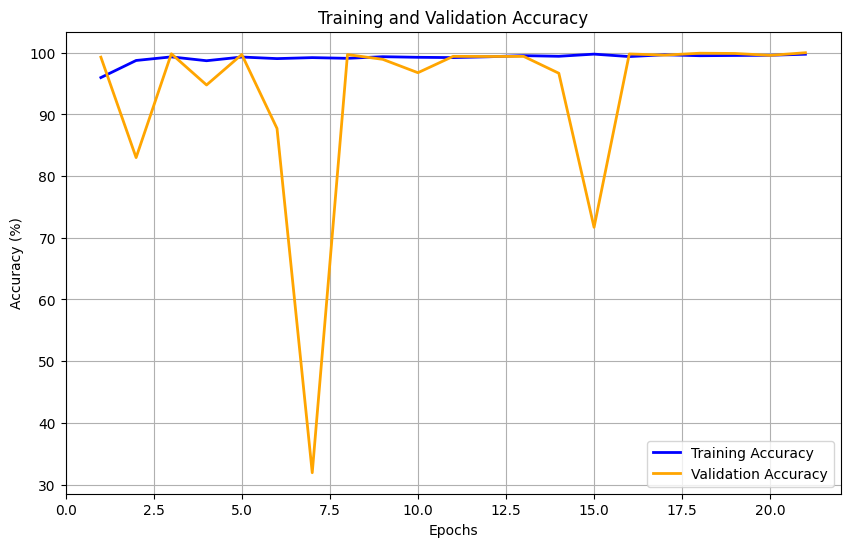

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), history_train, label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
plt.plot(range(1, epochs + 1), history_val, label='Validation Accuracy', color='orange', linestyle='-', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


---

Obtain Val Accuracy

---

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 100.00%


---

Save Model

---

In [17]:
torch.save(model, "Blood Smear.pth")